In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
from scipy import stats

In [2]:
ratings_df = pd.read_csv('data/ratings.csv')
to_read_df = pd.read_csv('data/to_read.csv')
books_df = pd.read_csv('data/books.csv')
tags_df = pd.read_csv('data/tags.csv')
book_tags_df = pd.read_csv('data/book_tags.csv')

<font size="5">Let's explore the dataset</font>

In [3]:
books_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
books_df.columns.tolist()

['book_id',
 'goodreads_book_id',
 'best_book_id',
 'work_id',
 'books_count',
 'isbn',
 'isbn13',
 'authors',
 'original_publication_year',
 'original_title',
 'title',
 'language_code',
 'average_rating',
 'ratings_count',
 'work_ratings_count',
 'work_text_reviews_count',
 'ratings_1',
 'ratings_2',
 'ratings_3',
 'ratings_4',
 'ratings_5',
 'image_url',
 'small_image_url']

In [5]:
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


<font size="5">First,Do we need to clean the data?</font>

In [6]:
#for the recommender system, we don't want a user rate the same book multiple times
#if such data entry exists, we need to clean it

duplicate = ratings_df[ratings_df.duplicated(['user_id', 'book_id'])]
duplicate

,user_id,book_id,rating


<font size="4">Looks like we don't need to do some major cleaning of the data. 
Let's continue to explore the data</font>

<font size="5">Now,let's do some preliminary examination with each data set</font>
<br>
<font size="3">Let's start with the ratings dataframe</font>

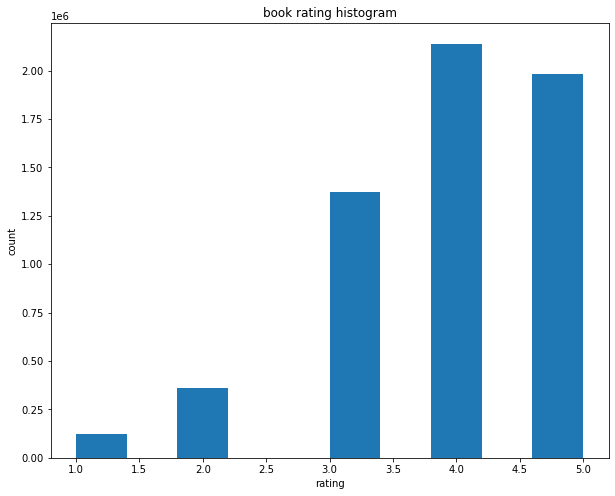

In [7]:
#let's plot the histogram of rating distribution
plt.hist(ratings_df.rating,bins = 10)
plt.xlabel('rating')
plt.ylabel('count')
plt.title('book rating histogram')
plt.show()

In [8]:
#let's see which books has the highest user rating
books_by_highest_rating_df = books_df.sort_values(by=['average_rating'], ascending=False)
books_by_highest_rating_df = books_by_highest_rating_df[['title','average_rating']].reset_index(drop = True)
books_by_highest_rating_df.head()

,title,average_rating
0,The Complete Calvin and Hobbes,4.82
1,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77
2,"Words of Radiance (The Stormlight Archive, #2)",4.77
3,Mark of the Lion Trilogy,4.76
4,ESV Study Bible,4.76


In [9]:
#let's see which books has the lowest user rating
books_by_lowest_rating_df = books_df.sort_values(by=['average_rating'], ascending=True)
books_by_lowest_rating_df = books_by_lowest_rating_df[['title','average_rating']].reset_index(drop = True)
books_by_lowest_rating_df.head()

,title,average_rating
0,One Night at the Call Center,2.47
1,The Almost Moon,2.67
2,The Finkler Question,2.76
3,Lost,2.80
4,Four Blondes,2.80


<font size="4">Let's now investigate the to_read data</font>

In [10]:
to_read_df.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [11]:
#let's see what books are most often marked as to_read by users
#provided that the book is at least marked by one user as to_read
BookId_CountToReadTag = list(to_read_df.book_id.value_counts().to_dict().items())
BookId_CountToReadTag = sorted(BookId_CountToReadTag,key = lambda x:x[1])

#the book that is least often marked with to_read
print('this book is least often marked with to_read')
print(books_df.iloc[BookId_CountToReadTag[0][0]].title)
print('number of people marked to_read tags',BookId_CountToReadTag[0][1])
print(' ')
#the book that is most often marked with ro_read
print('this book is most often marked with ro_read')
print(books_df.iloc[BookId_CountToReadTag[-1][0]].title)
print('number of people marked to_read tags',BookId_CountToReadTag[-1][1])

this book is least often marked with to_read
Twenty Years After (The D'Artagnan Romances, #2)
number of people marked to_read tags 1
 
this book is most often marked with ro_read
Fahrenheit 451
number of people marked to_read tags 2772


                            OLS Regression Results                            
Dep. Variable:            num_fo_read   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1559
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.693
Time:                        22:52:47   Log-Likelihood:                -64971.
No. Observations:               10000   AIC:                         1.299e+05
Df Residuals:                    9998   BIC:                         1.300e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.2395     25.297      4.002      0.0

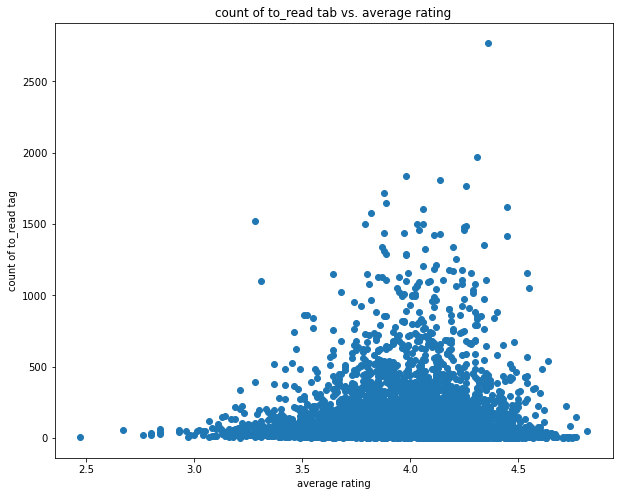

In [12]:
#let's see if there is a relationship between the average rating of a book
#and how often it's mark to ro_read by uesrs

#first, if there is any book that is not marked by to_read at all
#we need to find those books and add 0 tags to them
seen_book_id_set = set([a_tuple[0] for a_tuple in BookId_CountToReadTag])
padded_BookId_CountToReadTag = []
for book_id in books_df.book_id.tolist():
    if book_id not in seen_book_id_set:
        padded_BookId_CountToReadTag.append(tuple([book_id,0]))
padded_BookId_CountToReadTag += BookId_CountToReadTag

padded_BookId_CountToReadTag = sorted(padded_BookId_CountToReadTag,key = lambda x:x[0])
to_read_mark = [a_tuple[1] for a_tuple in padded_BookId_CountToReadTag]

AvgRating_ToRead_df = pd.DataFrame()
AvgRating_ToRead_df['avg_rating'] = books_df.average_rating
AvgRating_ToRead_df['num_fo_read'] = to_read_mark

x = AvgRating_ToRead_df.avg_rating
x = sm.add_constant(x)
y = AvgRating_ToRead_df.num_fo_read


model = sm.OLS(y,x).fit()
print(model.summary())

plt.scatter(AvgRating_ToRead_df.avg_rating,AvgRating_ToRead_df.num_fo_read)
plt.xlabel('average rating')
plt.ylabel('count of to_read tag')
plt.title('count of to_read tab vs. average rating')
plt.show()

<font size="3">We want to see if higher average rating of a book is a useful feature for predicting
that a book is more likely to be marked with a to_read tag by users. 

If there were a such positive correlation, we could model this relation by a linear regression 
with a positive slope.
However, with both the graph and the coefficient of the avg_rating and the 
p value of the avg_rating coefficient.
It's safe to draw the conclusion that there is no linear relation
between a book's average rating and how many users have marked to a book with the tag ro_read</font>

<font size="4">Let's now investigate the tags and book_tags data</font>

In [13]:
tags_df.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [14]:
book_tags_df.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [15]:
book_tags_df = book_tags_df.merge(tags_df, on = 'tag_id')
book_tags_df = book_tags_df.merge(books_df[['book_id','goodreads_book_id', 'title','average_rating']], on = 'goodreads_book_id' )
book_tags_df = book_tags_df.sort_values(by = ['average_rating'],ascending = False)
book_tags_df.reset_index(drop=True, inplace=True)
book_tags_df.head()

,goodreads_book_id,tag_id,count,tag_name,book_id,title,average_rating
0,24812,6134,6,calvin,3628,The Complete Calvin and Hobbes,4.82
1,24812,7746,44,comic-books,3628,The Complete Calvin and Hobbes,4.82
2,24812,27176,8,sequential-art,3628,The Complete Calvin and Hobbes,4.82
3,24812,7739,80,comic,3628,The Complete Calvin and Hobbes,4.82
4,24812,7824,7,comics-manga,3628,The Complete Calvin and Hobbes,4.82


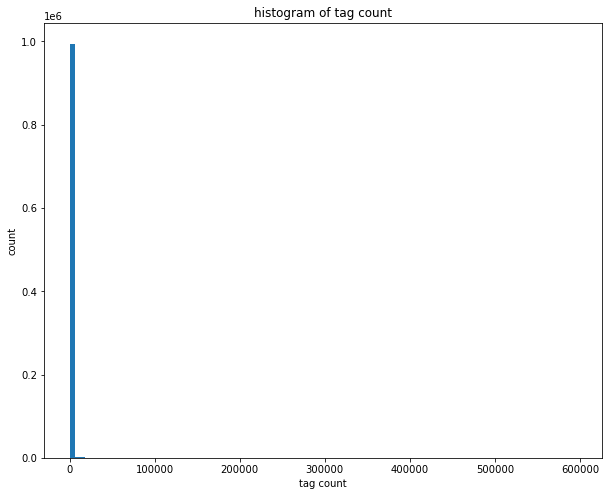

In [16]:
plt.hist(book_tags_df['count'],bins = 100)
plt.xlabel('tag count')
plt.ylabel('count')
plt.title('histogram of tag count')
plt.show()

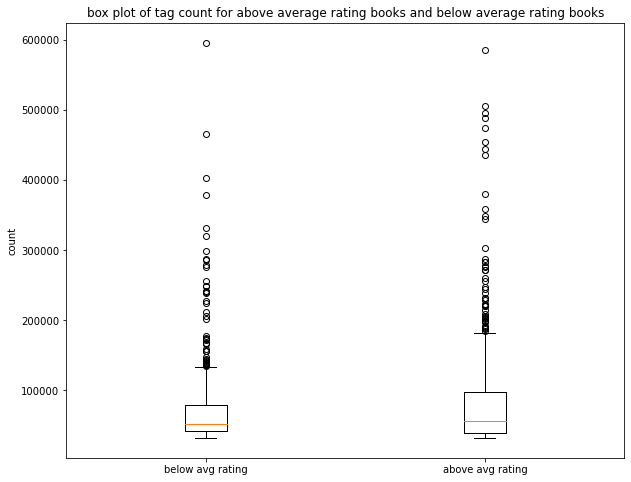

In [17]:
#let's use box plot to see if there is any relationship between 
#average rating and tag count
#based on the histogram above, we see that most of the tags counts are very small
#so, we are going to restrict ourselves to the top 0.999 quantile of the tags count
#that is, we want to ask that among tags that are very popular, is
#there is a relationship between average rating and tag count
book_tags_df = book_tags_df.sort_values(by = ['count'],ascending = False)
mean_of_avg_rating = book_tags_df.average_rating.mean()
sufficient_tag_count = np.quantile(book_tags_df['count'].tolist(), 0.999)

tag_count_below_avg_rating = []
tag_count_above_avg_rating = []

for row_index in range(0,book_tags_df.shape[0]):
    row = book_tags_df.iloc[row_index]
    if row['count'] < sufficient_tag_count:
        break
    if row.average_rating > mean_of_avg_rating:
        tag_count_above_avg_rating.append(row['count'])
    else:
        tag_count_below_avg_rating.append(row['count'])
        
box_plot_data = [tag_count_below_avg_rating,tag_count_above_avg_rating]

plt.boxplot(box_plot_data)
plt.xticks([1, 2], ['below avg rating', 'above avg rating'])
plt.ylabel('count')
plt.title('box plot of tag count for above average rating books and below average rating books')
plt.show()

In [18]:
#based on the box plot, we cannot visually draw any conclusion.
#let's use hypothesis testing to see if there is any measurable difference
#let's test if the mean of the tag count is different for the two categories
#we will see two-sided testing
stats.ttest_ind(tag_count_below_avg_rating, tag_count_above_avg_rating, equal_var = False)

Ttest_indResult(statistic=-2.8982019696003625, pvalue=0.003839532960913888)

<font size="3">Based on the hypothesis testing, it looks like that with high confidence
we can draw the conclusion that with sufficient tags, books above average rating tend to have more tags</font>